# Instantaneous Frequency Estimation

In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

from scipy import signal
from scipy import ndimage
import librosa.display
import IPython.display as ipd
from IPython.display import Image, Audio

path_img = '../img/9.musically_informed_audio_decomposition/'
path_data = '../data_FMP/'

from utils.plot_tools import *
from utils.feature_tools import f_pitch

- 다음에서는 **순간(instantaneous) 주파수 추정**이라는 기술을 소개한다.
- STFT의 위상(phase) 정보를 보고 도출된 추정치는 STFT에 의해 도입된 주파수 양자화(quantization)를 개선할 수 있도록 한다.

- 기존의 일부 표기법을 수정하여 이산 STFT의 일부 속성을 보자.
- $x$는 $F_\mathrm{s}$ 헤르츠의 비율로 샘플링된 주어진 음악 신호를 나타낸다. 또한, $\mathcal{X}$를 길이 $N\in\mathbb{N}$ 및 홉 크기 $H\in\mathbb{N}$의 적절한 윈도우 함수를 사용하는 STFT라고 하자.
- 푸리에 계수 $\mathcal{X}(n,k)$의 경우, 프레임 인덱스 $n\in\mathbb{Z}$는 물리적 시간 $T_\mathrm{coef}(n) := \frac{n\cdot H}{F_\mathrm{s}}$ (초 단위)와 관련되어 있다. 주파수 지수 $k\in[0:N/2]$는 주파수 $F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{N} $(헤르츠로 표시)에 해당한다.


- 특히 이산 STFT는 $F_\mathrm{s}/N$Hz의 분해능(resolution)으로 주파수 축의 선형 샘플링을 할 수 있다. 그러나 이 분해능은 특정 시간-주파수 패턴(예: 비브라토 또는 글리산도로 인해 지속적으로 변화하는 패턴)을 정확하게 캡처하는 데 충분하지 않을 수 있다. 또한, 주파수의 로그 인식으로 인해, 주파수 축의 선형 샘플링은 스펙트럼의 저주파(low-frequency) 부분에서 특히 문제가 된다. 단순히 윈도우 길이 $N$을 증가시켜 주파수 분해능을 높이는 것은 실행 가능한 솔루션이 아니다. 이 프로세스는 시간적(temporal) 분해능을 감소시키기 때문이다.
- 다음에서는 복소수 STFT로 인코딩된 위상 정보를 이용하여 향상된 주파수 추정을 얻는 기법에 대해 논의한다.

## 순간 주파수 (Instantaneous Frequency)

- 우선 주파수 표현 및 측정의 주요 아이디어를 상기해보자. 다음 형식의 복소수 **지수 함수**를 고려한다.
    - $\mathbf{exp}_{\omega,\varphi}:\mathbb{R}\to\mathbb{C}, \quad \mathbf{exp}_\omega(t):= \mathrm{exp}\big (2\pi i(\omega t - \varphi)\big)$
    - 주파수 매개변수 $\omega\in\mathbb{R}$($\mathrm{Hz}$로 측정) 및 위상 매개변수 $\varphi$($360^\circ$의 각도에 해당하는 $1$로 정규화된 라디안으로 측정).
- $\varphi=0$인 경우,
     - $\mathbf{exp}_{\omega} := \mathbf{exp}_{\omega,0}.$


- 시간 매개변수 $t$를 균일하게 증가시키면, 지수 함수는 단위 원(unit circle) 주위의 **원 운동**(**circular motion**)을 설명한다. 실제 및 가상 축에 투영하면 두 개의 **정현파 운동**(**sinusoidal motions**)(코사인 및 사인 함수로 설명됨)이 생성된다.
- 원형 운동을 균일하게 회전하는 바퀴로 생각하면 주파수 매개변수 $\omega$는 단위 시간당 회전 수(이 경우 1초 지속 시간)에 해당한다. 즉, 주파수는 회전율로 해석할 수 있다.
- 이 해석을 기반으로 임의의 시간 간격 $[t_1,t_2]$ 및 $t_1<t_2$ 동안 회전하는 바퀴와 주파수 값을 연결할 수 있다. 이를 위해 시간 $t_1$에서의 각도 위치 $\varphi_1$와 시간 $t_2$에서의 각도 위치 $\varphi_2$를 측정한다. 이는 다음 그림에 설명되어 있다.

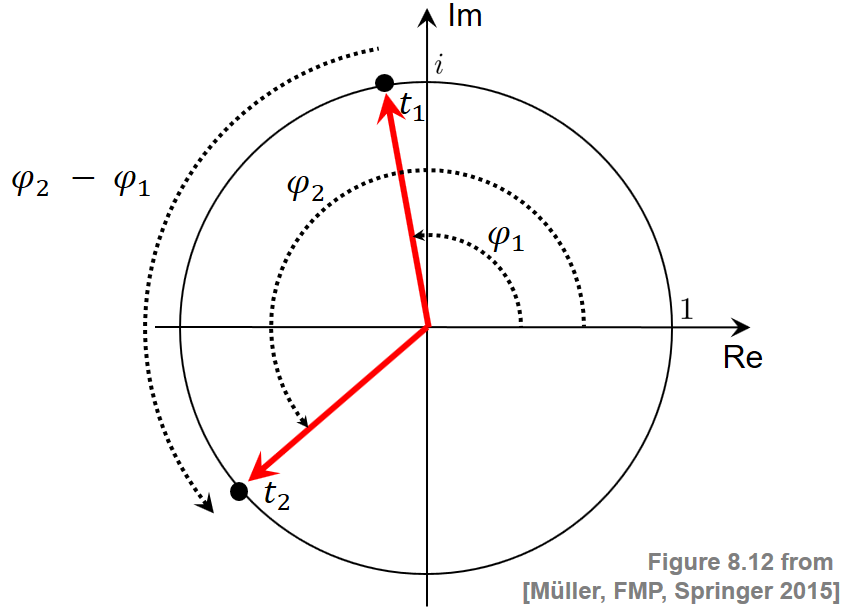

In [4]:
Image(path_img+"FMP_C8_F12.png", width="300px")

- 주파수는 시간 간격의 길이 $t_2-t_1$로 나눈 각도 위치의 변화 $\varphi_2-\varphi_1$로 정의된다.
- 극한의 경우, 시간 간격이 임의로 작아지면 다음과 같이 주어진 **순간 주파수** $\omega_{t_1}$를 얻는다.
     - $ \omega_{t_1}:=\lim_{t_2\to t_1}\frac{\varphi_2-\varphi_1}{t_2-t_1}.$

## 위상 예측 오류 Phase Prediction Error

- 주파수 값 $\omega\in\mathbb{R}$과 두 개의 시간 인스턴스($t_1\in\mathbb{R}$, $t_2\in\mathbb{R}$)를 고정하는 시간-연속적 관점을 가정해 보자. 
- 나중에 STFT 매개변수와 관련된 특정 값을 선택할 것이다. 신호 $x$를 윈도우 버전의 분석 함수 $\mathbf{exp}_\omega$(하나는 $t_1$에, 다른 하나는 $t_2$에 위치)와 연관시키면, 두 개의 복소 푸리에 계수를 얻는다.
- $\varphi_1$와 $\varphi_2$를 각각 이 두 계수의 위상이라 하자.
- 신호 $x$가 주파수 $\omega$의 강한 주파수 성분을 포함하는 경우, $\varphi_1$ 및 $\varphi_2$의 두 위상은 다음과 같은 방식으로 일치해야 한다. : 시간 위치 $t_1$에서 각도 위치 $\varphi_1$를 가정하는 주파수 $\omega$의 회전(rotation)이 시간 $t_2$에서 위상 $\varphi^\mathrm{Pred}:=\varphi_1 + \omega\cdot \Delta t$를 가져야 한다.($\Delta t:=t_2-t_1$)
    
- 따라서 신호 $x$가 함수 $\mathbf{exp}_\omega$와 유사하게 동작하는 경우 $\varphi_2\approx\varphi^\mathrm{Pred}$이어야 한다. $x$ 신호가 $\mathbf{exp}_\omega$보다 약간 느리게 진동(oscillate)하는 경우 $x$ 신호에 대한 인스턴스 $t_1$에서 인스턴스 $t_2$까지의 위상 증분은  프로토타입 진동 $\mathbf{exp}_\omega$에 대한 것보다 작다. 결과적으로 $t_2$에서 측정된 위상 $\varphi_2$는 예측 위상 $\varphi^\mathrm{Pred}$보다 작다. $x$가 $\mathbf{exp}_\omega$보다 약간 빠르게 진동하는 세 번째 경우에서 $\varphi_2$ 위상은 예측 위상 $\varphi^\mathrm{Pred}$보다 크다. 세 가지 경우를 다음 그림으로 설명한다.

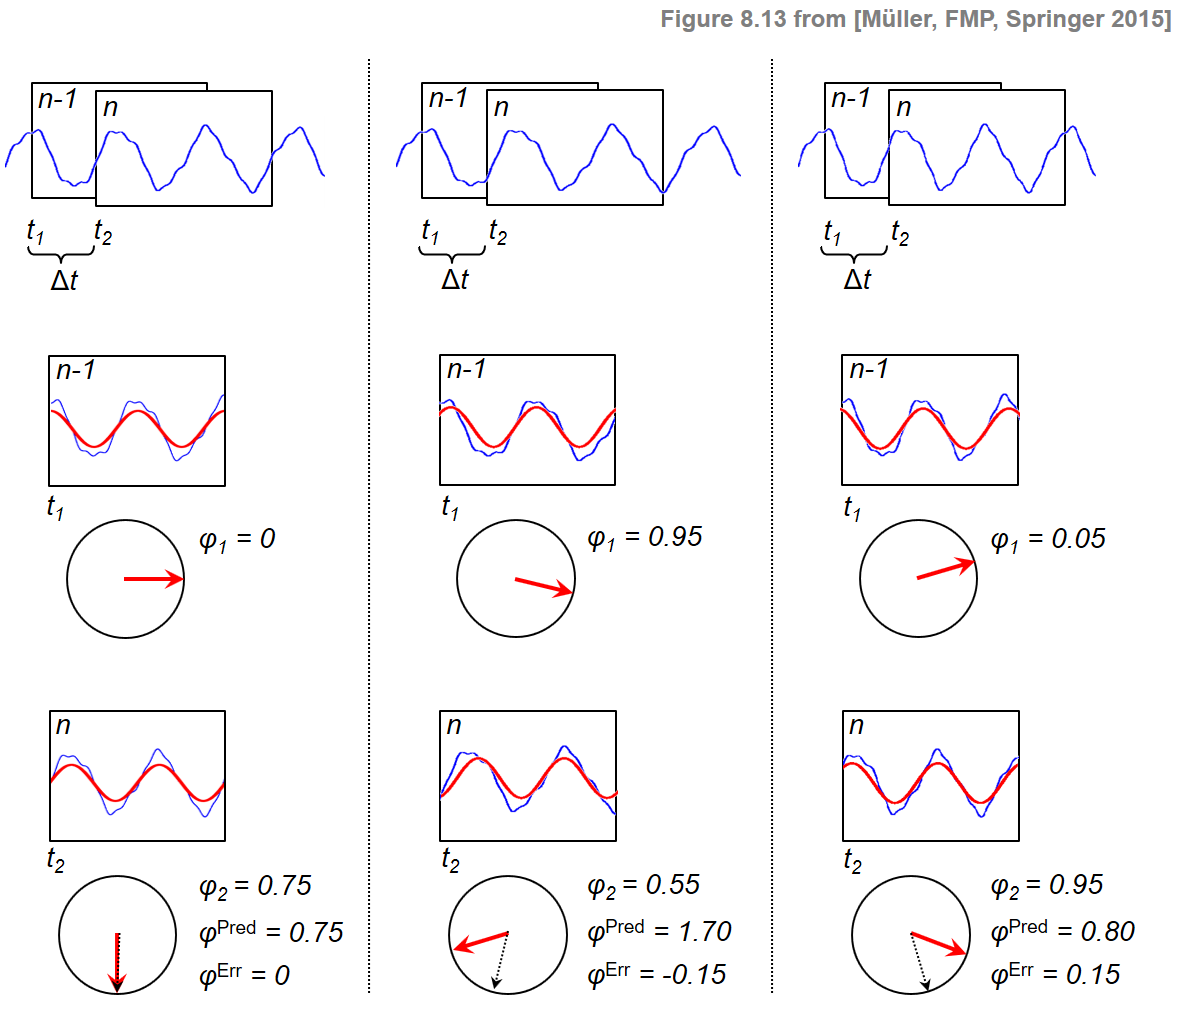

In [5]:
Image(path_img+"FMP_C8_F13.png", width="500px")

- $\varphi_2$와 $\varphi^\mathrm{Pred}$의 차이를 측정하기 위해 다음과 같이 정의된 **예측 오류**를 도입한다.
    - $\varphi^\mathrm{Err}:=\Psi(\varphi_2-\varphi^\mathrm{Pred}).$
- 이 정의에서 $\Psi:\mathbb{R}\to\left[-0.5,0.5\right]$는 **principal argument function**이며, 적절한 정수 값을 더하거나 빼서 위상차를 $[-0.5,0.5]$ 범위로 매핑한다. 이는 위상 차이를 계산할 때 불연속성을 방지한다. 
- 예측 오류는 신호 $x$에 대한 정제된 주파수 추정 $\mathrm{IF}(\omega)$를 얻기 위해 주파수 값 $\omega$를 수정하는 데 사용할 수 있다.
    - - $\mathrm{IF}(\omega) :=  \omega + \frac{\varphi^\mathrm{Err}}{\Delta t}.$

- 이 값은 **순간 주파수**(**instantaneous frequency**)(IF)라고도 하며 초기 주파수 $\omega$의 조정으로 생각할 수 있다.
- 엄밀히 말하면, 순간 빈도는 단일 시간 인스턴스를 참조하는 것이 아니라 전체 시간 간격 $[t_1,t_2]$를 참조한다. 그러나 실제로 이 간격은 일반적으로 매우 작게 선택된다(대략 몇 밀리초(milliseconds)).

## STFT 주파수 분해능 개선

- 이제 이산 STFT의 주파수 분해능을 개선하기 위해 순간 주파수 개념을 적용한다. 극좌표 표현을 사용하여 푸리에 계수 $\mathcal{X}(n,k)\in\mathbb{C}$를 다음과 같이 쓸 수 있다.
    - $ \mathcal{X}(n,k)= |\mathcal{X}(n,k)|\mathrm{exp}(2\pi i\varphi(n,k))$ 
    - 위상 $\varphi(n,k)\in[0,1)$.

- 프로토타입 진동의 경우, 주파수 매개변수 $k\in[0:N/2]$에 의해 결정되는 주파수를 사용한다.
    - $ \omega = F_\mathrm{coef}(k) = \frac{k\cdot F_\mathrm{s}}{N}.$

- 또한 두 시간 인스턴스는 이전 프레임과 현재 프레임의 위치에 따라 결정된다.
    - $t_1=T_\mathrm{coef}(n-1)=\frac{(n-1)\cdot H}{F_\mathrm{s}} \quad , \quad
         t_2=T_\mathrm{coef}(n)=\frac{n\cdot H}{F_\mathrm{s}}.$


- 마지막으로 이러한 시간 인스턴스에서 측정된 위상은 STFT에서 얻은 것이다.
    - $\varphi_1=\varphi(n-1,k) \quad,\quad
     \varphi_2=\varphi(n,k).$

- 이로부터 위의 방정식들을 사용하고 약간의 재정렬을 수행하여 순간 주파수를 얻는다.
    - $F_\mathrm{coef}^\mathrm{IF}(k,n):=\mathrm{IF}(\omega) = \left( k + \kappa(k,n) \right)\cdot\frac{F_\mathrm{s}}{N}$
    - **bin offset**  $\kappa(k,n) = \frac{N}{H}\cdot\Psi\left(\varphi(n,k)-\varphi(n-1,k) - \frac{k\cdot H}{N}\right)$

## 구현

- 다음 코드 셀에서는 주어진 STFT의 모든 시간-주파수 빈에 대한 순간 주파수(IF)를 추정하는 구현을 제공한다.
    * 입력은 샘플링 속도 'Fs', 윈도우 길이 'N', 홉 크기 'H' , 그리고 차원 'K'(주파수 빈 수) 및 'L'(프레임 수)의 복소수 값 STFT 행렬 'X'로 구성된다.
    * 출력은 각 시간-주파수 빈에 대한 IF의 추정치를 포함하는 실수 값 행렬 `F_coef_IF`이다. `F_coef_IF`도 (`K` $\times$ `L`)-행렬이 되도록 패딩을 적용한다.
    * 구현에서 IF는 행렬 연산을 사용하여 모든 시간-주파수 빈에 대해 동시에 계산된다.

In [6]:
def principal_argument(v):
    """Principal argument function

    Args:
        v (float or np.ndarray): Value (or vector of values)

    Returns:
        w (float or np.ndarray): Principle value of v
    """
    w = np.mod(v + 0.5, 1) - 0.5
    return w


def compute_if(X, Fs, N, H):
    """Instantenous frequency (IF) estamation

    Args:
        X (np.ndarray): STFT
        Fs (scalar): Sampling rate
        N (int): Window size in samples
        H (int): Hop size in samples

    Returns:
        F_coef_IF (np.ndarray): Matrix of IF values
    """
    phi_1 = np.angle(X[:, 0:-1]) / (2 * np.pi)
    phi_2 = np.angle(X[:, 1:]) / (2 * np.pi)

    K = X.shape[0]
    index_k = np.arange(0, K).reshape(-1, 1)
    # Bin offset (FMP, Eq. (8.45))
    kappa = (N / H) * principal_argument(phi_2 - phi_1 - index_k * H / N)
    # Instantaneous frequencies (FMP, Eq. (8.44))
    F_coef_IF = (index_k + kappa) * Fs / N

    # Extend F_coef_IF by copying first column to match dimensions of X
    F_coef_IF = np.hstack((np.copy(F_coef_IF[:, 0]).reshape(-1, 1), F_coef_IF))

    return F_coef_IF

## IF 시각화

- 이제 IF 추정 절차에 대한 더 깊은 통찰력을 제공하는 시각화를 소개한다. 예를 들어, 피아노로 연주되는 $\mathrm{C4}$의 단일 음 또는 녹음을 고려하자. 이 음은 중심 주파수가 $261.6~\mathrm{Hz}$, MIDI 피치 $p=60$에 해당한다. 다음 그림은 오디오 신호의 파형과 스펙트로그램 표현을 보여준다.

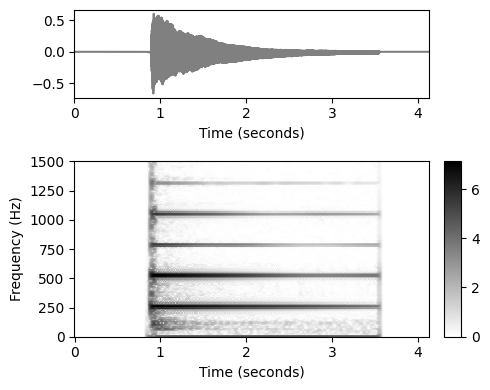

In [7]:
fn_wav = 'FMP_C6_F04_NoteC4_Piano.wav'
x, Fs = librosa.load(path_data+fn_wav)
ipd.display(Audio(data=x,rate=Fs))

N = 2048
H = 64
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
Y = np.log(1+ 10*np.abs(X))
K = X.shape[0]
L = X.shape[1]
ylim = [0,1500]

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                          'height_ratios': [1, 2]}, figsize=(5, 4))        

plot_signal(x, Fs, ax=ax[0,0])
ax[0,1].set_axis_off()
plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[1,0],ax[1,1]], colorbar=True)
ax[1,0].set_ylim(ylim)
plt.tight_layout()

- IF 추정의 출력은 주파수 값 $F_\mathrm{coef}^\mathrm{IF}(k,n)\in\mathbb{R}$(Hertz로 제공됨)이다($k\in[0:K-1]$, $n\in[0:L-1]$).

- 이 값은 STFT의 $k$번째 푸리에 계수와 관련된 (프레임 독립적인) 주파수 값 $F_\mathrm{th}$의 개선이다.

- 다음 그림에서 $F_\mathrm{coef}$ 및 $F_\mathrm{coef}^\mathrm{IF}$에 의해 주어진 $(K\times N)$-행렬을 색상 코드 형태로 표시한다. 

- 또한 Hertz로 지정된 bin offset인 차이를 시각화한다.
    - $F_\mathrm{coef}^\mathrm{IF}-F_\mathrm{coef} = \kappa \cdot\frac{N}{F_\mathrm{s}}$
    
- 스펙트로그램을 시각화(크기(magnitude)가 색상으로 구분됨)하는 것과 반대로 이번에는 **주파수 값을 시각화**(헤르츠로 표시됨)한다.

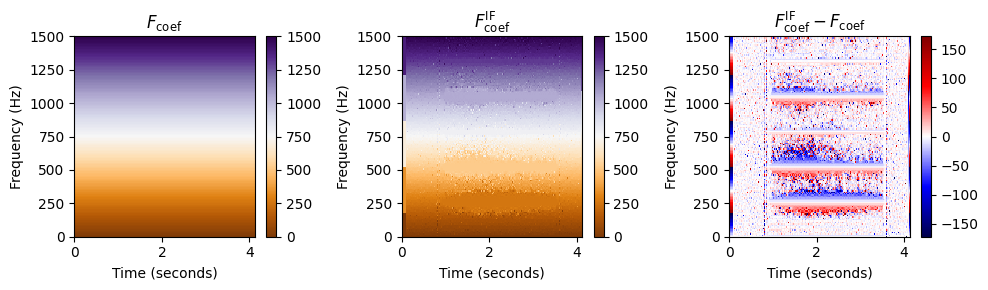

In [8]:
def plot_IF(F_coef_X, F_coef_IF, ylim, figsize=(10,3)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,3,1)
    plot_matrix(F_coef_X, Fs=Fs/H, Fs_F=N/Fs, cmap='PuOr', clim=ylim, ax=[ax],
            title=r'$F_\mathrm{coef}$')
    plt.ylim(ylim)
    ax = plt.subplot(1,3,2)
    plot_matrix(F_coef_IF, Fs=Fs/H, Fs_F=N/Fs, cmap='PuOr', clim=ylim, ax=[ax],
            title=r'$F_\mathrm{coef}^\mathrm{IF}$')
    plt.ylim(ylim)
    ax = plt.subplot(1,3,3)
    plot_matrix(F_coef_IF-F_coef_X, Fs=Fs/H, Fs_F=N/Fs, cmap='seismic', ax=[ax],
            title=r'$F_\mathrm{coef}^\mathrm{IF}-F_\mathrm{coef}$')
    plt.ylim(ylim)
    plt.tight_layout()
    
F_coef_IF = compute_if(X, Fs, N, H)
F_coef = np.arange(K) * Fs / N
F_coef_X = np.ones((K,L)) * F_coef.reshape(-1,1)
plot_IF(F_coef_X, F_coef_IF, ylim)    

- 이 시각화에서 행렬 $F_\mathrm{coef}$와 $F_\mathrm{coef}^\mathrm{IF}$는 상당히 유사해 보인다. 그러나 차이를 볼 때 음표 $\mathrm{C4}$ ($261.6~\mathrm{Hz}$)의 기본 주파수와 그 고조파의 영역에서 주파수 값의 조정을 명확하게 볼 수 있다.
- 고조파 바로 아래의 주파수 값은 위로 조정되고(빨간색) 고조파 바로 위의 주파수 값은 아래로 보정된다(파란색).

- 다음 그림에서는 주파수 값에 대한 색상 코딩을 조정하면서 기본 주파수 $261.6~\mathrm{Hz}$ 부근을 확대한다. 이 시각화는 IF 추정 절차가 $261.6~\mathrm{Hz}$ 부근의 모든 주파수 계수를 정확히 해당 주파수에 할당함을 보여준다.

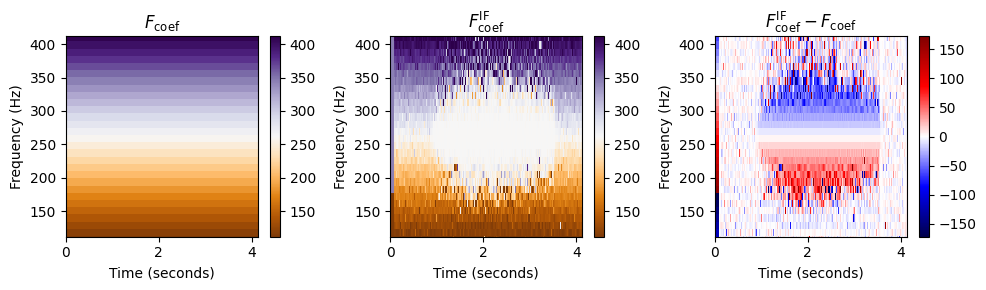

In [9]:
# Compute a neighborhood around center frequency of C4 (p=60)
pitch = 60
freq_fund = 2 ** ((pitch - 69) / 12) * 440
freq_0 = freq_fund-150
freq_1 = freq_fund+150
ylim = [freq_0, freq_1]

plot_IF(F_coef_X, F_coef_IF, ylim)  

## 홉 크기에 따라서

- 추정된 순간 주파수의 품질은 다음의 두 연속된 프레임 사이의 길이에 따라 달라진다.
    - $\Delta t=t_2-t_1 = T_\mathrm{coef}(n) - T_\mathrm{coef}(n-1) = H/F_\mathrm{s}$
- 따라서 이산 STFT에 적용할 때 **작은 홉 크기** $H$를 사용하는 것이 유리하다. 이는 다음 그림에 설명되어 있다. 단, 단점은 작은 홉 크기를 사용하면 이산 STFT를 계산하기 위한 계산 비용이 증가한다는 것이다.

Instanteneous frequency estimation using N=2048 and H=64
Runtime (STFT): 0.03592920 seconds
Runtime (IF): 0.14359021 seconds


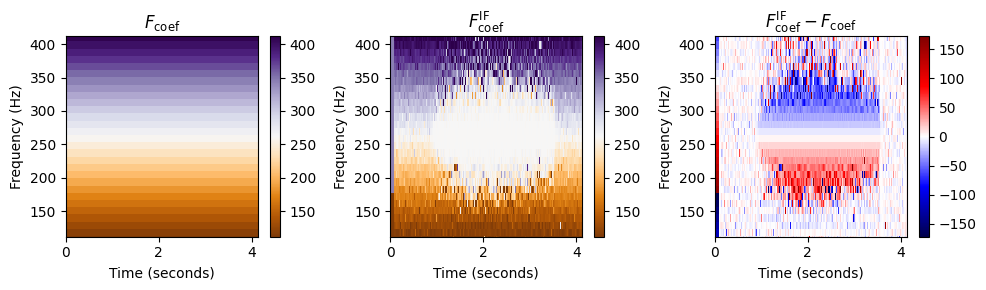

Instanteneous frequency estimation using N=2048 and H=256
Runtime (STFT): 0.01000023 seconds
Runtime (IF): 0.03391099 seconds


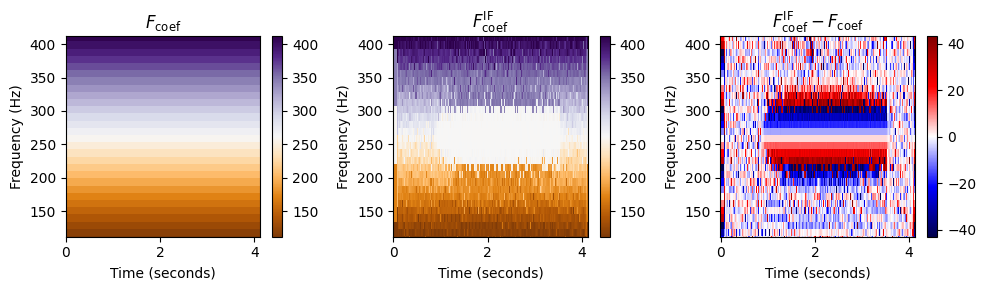

Instanteneous frequency estimation using N=2048 and H=1024
Runtime (STFT): 0.00296688 seconds
Runtime (IF): 0.00797987 seconds


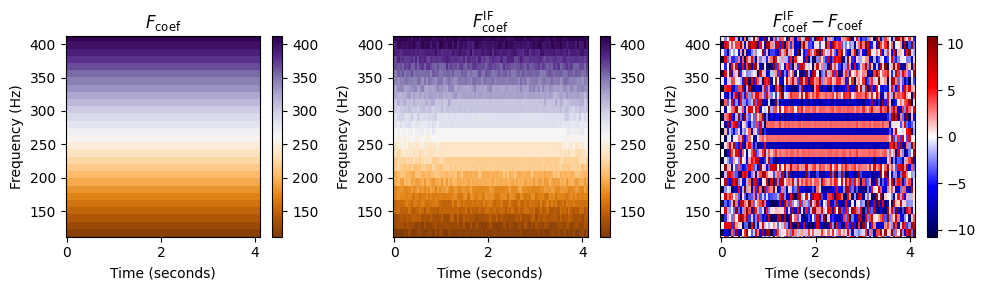

In [10]:
import time

def compute_plot_IF(x, N, H):
    
    # Compute STFT
    start = time.time()
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    Y = np.log(1+ 10*np.abs(X))
    end = time.time()
    print('Runtime (STFT): %.8f seconds' % (end - start))    
    K = X.shape[0]
    L = X.shape[1]
    
    # Compute IF
    start = time.time()
    F_coef_IF = compute_if(X, Fs, N, H)
    end = time.time()
    print('Runtime (IF): %.8f seconds' % (end - start))    
    
    # Plot
    F_coef = np.arange(K) * Fs / N
    F_coef_X = np.ones((K,L)) * F_coef.reshape(-1,1)
    plot_IF(F_coef_X, F_coef_IF, ylim) 
    plt.show()
    
    
N, H = 2048, 64
print('Instanteneous frequency estimation using N=%d and H=%d'%(N,H))
compute_plot_IF(x, N, H)

N, H = 2048, 256
print('Instanteneous frequency estimation using N=%d and H=%d'%(N,H))
compute_plot_IF(x, N, H)

N, H = 2048, 1024
print('Instanteneous frequency estimation using N=%d and H=%d'%(N,H))
compute_plot_IF(x, N, H)

# Salience Representation

- 향상된 로그-주파수 스펙트로그램인 salience 표현을 소개한다.

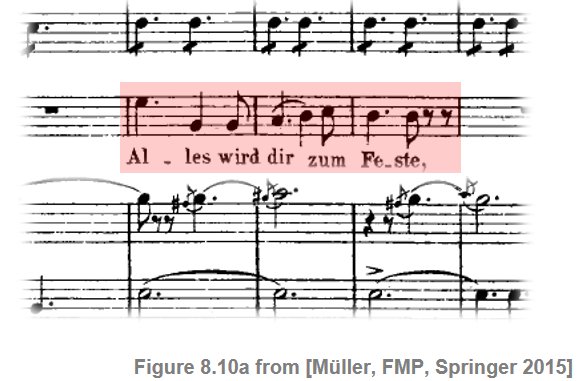

In [11]:
# 사용할 예시 오디오
ipd.display(Image(path_img+"FMP_C8_F10a.png", width="300px"))
fn_wav = "FMP_C8_F10_Weber_Freischuetz-06_FreiDi-35-40.wav"
ipd.display(Audio(path_data+fn_wav))

- 다음 그림은 오디오 발췌 부분의 로그 압축된 스펙트로그램과 확대된 시간-주파수 섹션을 보여준다. 사용할 순간 주파수를 고려하여 상대적으로 작은 홉 크기 파라미터 $H$를 선택했다.

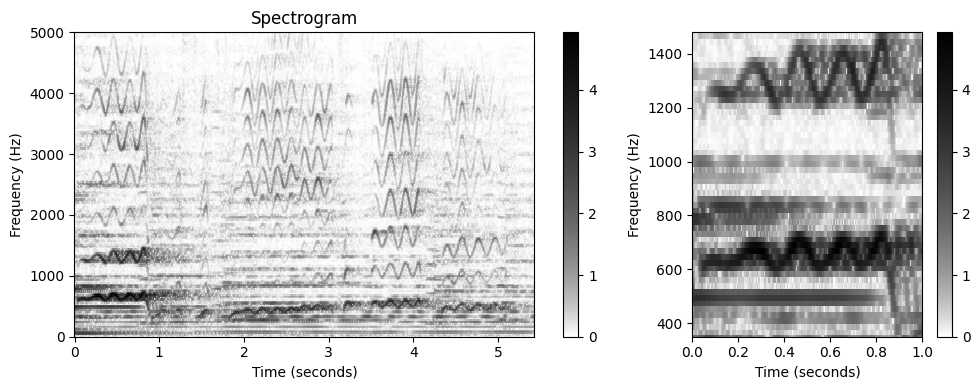

In [12]:
x, Fs = librosa.load(path_data+fn_wav)

# Computation of STFT
N = 1024
H = 128
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, pad_mode='constant')
gamma = 1
Y = np.log(1 + gamma * np.abs(X))


figsize = (10,4)
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)        

ylim_zoom_pitch = [65, 90] 
ylim_zoom = [f_pitch(ylim_zoom_pitch[0]), f_pitch(ylim_zoom_pitch[1])]
xlim_zoom = [0,1]
cmap = compressed_gray_cmap(alpha=5)

plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[0]], title='Spectrogram', 
                     colorbar=True, cmap=cmap);
ax[0].set_ylim([0, 5000])
plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[1]], title='', 
                     colorbar=True, cmap=cmap);
ax[1].set_ylim(ylim_zoom)
ax[1].set_xlim(xlim_zoom)

plt.tight_layout()

## Log-Frequency Spectrogram 

- 로그-주파수 스펙트로그램을 생각해보자. $x$는 $F_\mathrm{s}$ 레이트로 샘플링되고 윈도우 길이 $N\in\mathbb{N}$ 및 홉 크기 $H\in\mathbb{N}$를 사용한 STFT $\mathcal{X}$ 오디오 신호를 나타낸다. 주파수 지수 $k\in[0:N/2]$는 $F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{N}$ (헤르츠로 주어짐)에 해당한다.

- 로그 주파수 스펙트로그램을 얻기 위한 한 가지 전략은 피치 매개변수 $p\in[0:127]$에 대한 집합 $P(p) := \{k:F_\mathrm{MIDI}(p-0.5) \leq F_\mathrm{coef}(k) < F_\mathrm{MIDI}(p+0.5)\}$에 관한 STFT 계수를 풀링(pool)하거나 비닝(bin)하는 것이다.

- 중심 주파수는 $ F_\mathrm{MIDI}(p) = 2^{(p-69)/12} \cdot 440 $로 주어진다.

- 피치를 고정하고 결과 피치 밴드에 있는 모든 주파수를 찾는 대신, 주어진 주파수로 피치 인덱스를 할당하는 $\mathrm{Bin}:\mathbb{R}\to\mathbb{Z}$ 매핑을 정의할 수도 있다.:
     - $\mathrm{Bin}(\omega) := \left\lfloor 12\cdot\log_2\left(\frac{\omega}{440}\right)+69.5\right\rfloor.$
- 이 함수를 이용하여 비닝(binning)을 다음과 같이 표현할 수 있다.
     - $P(p) := \{k: \mathrm{Bin}(F_\mathrm{coef}(k))=p\}.$
- 여기에서 풀링을 통해 로그 주파수 스펙트로그램 $\mathcal{Y}_\mathrm{LF}:\mathbb{Z}\times [0:127]$를 얻는다.
     - $ \mathcal{Y}_\mathrm{LF}(n,p) := \sum_{k \in P(p)}{|\mathcal{X}(n,k)|^2}.$

In [20]:
def f_coef(k, Fs, N):
    """STFT center frequency
    Args:
        k (int): Coefficient number
        Fs  (scalar): Sampling rate in Hz
        N (int): Window length in samples
    Returns:
        freq (float): STFT center frequency
    """
    return k * Fs / N


def frequency_to_bin_index(F, R=10.0, F_ref=55.0):
    """| Binning function with variable frequency resolution
    | Note: Indexing starts with 0 (opposed to [FMP, Eq. (8.49)])
    Args:
        F (float): Frequency in Hz
        R (float): Frequency resolution in cents (Default value = 10.0)
        F_ref (float): Reference frequency in Hz (Default value = 55.0)
    Returns:
        bin_index (int): Index for bin (starting with index 0)
    """
    bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
    return bin_index


def p_bin(b, freq, R=10.0, F_ref=55.0):
    """Computes binning mask [FMP, Eq. (8.50)]
    Args:
        b (int): Bin index
        freq (float): Center frequency
        R (float): Frequency resolution in cents (Default value = 10.0)
        F_ref (float): Reference frequency in Hz (Default value = 55.0)
    Returns:
        mask (float): Binning mask
    """
    mask = frequency_to_bin_index(freq, R, F_ref) == b
    mask = mask.reshape(-1, 1)
    return mask


def compute_y_lf_bin(Y, Fs, N, R=10.0, F_min=55.0, F_max=1760.0):
    """Log-frequency Spectrogram with variable frequency resolution using binning
    Args:
        Y (np.ndarray): Magnitude spectrogram
        Fs (scalar): Sampling rate in Hz
        N (int): Window length in samples
        R (float): Frequency resolution in cents (Default value = 10.0)
        F_min (float): Lower frequency bound (reference frequency) (Default value = 55.0)
        F_max (float): Upper frequency bound (is included) (Default value = 1760.0)
    Returns:
        Y_LF_bin (np.ndarray): Binned log-frequency spectrogram
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        F_coef_cents (np.ndarray): Frequency axis in cents
    """
    # [FMP, Eq. (8.51)]
    B = frequency_to_bin_index(np.array([F_max]), R, F_min)[0] + 1
    F_coef_hertz = 2 ** (np.arange(0, B) * R / 1200) * F_min
    F_coef_cents = np.arange(0, B*R, R)
    Y_LF_bin = np.zeros((B, Y.shape[1]))

    K = Y.shape[0]
    freq = f_coef(np.arange(0, K), Fs, N)
    freq_lim_idx = np.where(np.logical_and(freq >= F_min, freq <= F_max))[0]
    freq_lim = freq[freq_lim_idx]
    Y_lim = Y[freq_lim_idx, :]

    for b in range(B):
        coef_mask = p_bin(b, freq_lim, R, F_min)
        Y_LF_bin[b, :] = (Y_lim*coef_mask).sum(axis=0)
    return Y_LF_bin, F_coef_hertz, F_coef_cents

- 다음 코드 셀은 Freischütz예의 로그-주파수 스펙토그램을 나타낸다.

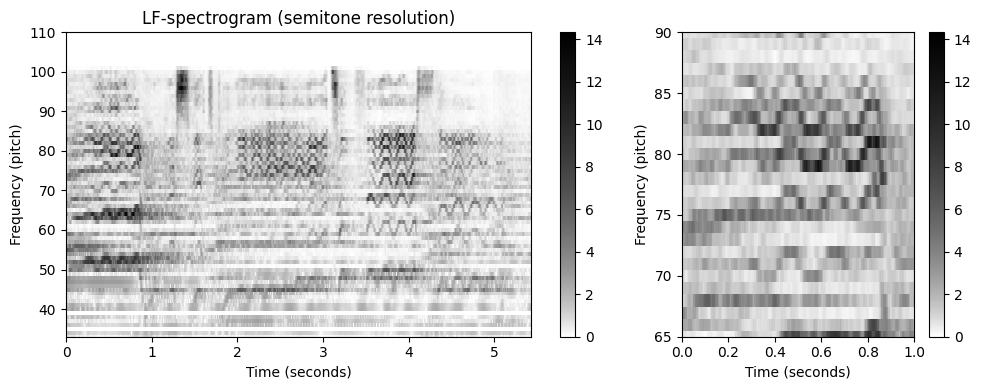

In [21]:
Y_LF, F_coef_hertz, F_coef_cents = compute_y_lf_bin(Y, Fs, N, R=100, F_min=32.703, F_max=11025)  

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)         

plot_matrix(Y_LF, Fs=Fs/H, Fs_F=1, ax=[ax[0]], ylabel='Frequency (pitch)',
                     title='LF-spectrogram (semitone resolution)', 
                     colorbar=True, cmap=cmap);
ax[0].set_ylim([33, 110])
plot_matrix(Y_LF, Fs=Fs/H, Fs_F=1, ax=[ax[1]], ylabel='Frequency (pitch)',
                     title='', colorbar=True, cmap=cmap);
ax[1].set_ylim(ylim_zoom_pitch)
ax[1].set_xlim(xlim_zoom)
plt.tight_layout()

## Refined Binning

- 이제 보다 일반적인 빈 할당(bin assignment)을 고려하여 로그 주파수 스펙트로그램의 정의를 확장한다.
- 이를 위해 $\omega_\mathrm{ref}\in\mathbb{R}$를 빈 인덱스 $1$에 할당할 참고 주파수라 하자. 또한, $R\in\mathbb{R}$(센트 단위)를 대수적(loagrithmically)으로 간격을 둔 주파수 축의 원하는 분해능(resolution)이라고 하자.
- 그러면 주파수 $\omega\in\mathbb{R}$(Hertz로 표시)에 대해 빈(bin) 인덱스 $\mathrm{Bin}(\omega)$는 다음과 같이 정의된다.
     - $\mathrm{Bin}(\omega) := \left\lfloor \frac{1200}{R} \cdot\log_2\left(\frac{\omega}{\omega_\mathrm{ref}}\right)+1.5\right\rfloor.$
     

- 예를 들어, $R=100$는 빈당 $100$ 센트(1반음)의 분해능으로 주파수 축의 세분화를 산출한다. $R=10$을 사용하면 각 빈이 $10$ 센트(반음의 10분의 1)에 해당하도록 더 미세하게 세분화된다.
- 빈 매핑 함수를 기반으로 위의 로그 주파수 스펙트로그램의 정의를 확장해보자. 참조 주파수 $\omega_\mathrm{ref}$ 및 분해능 $R$을 고정하고 $B\in\mathbb{N}$를 고려할 빈의 수로 둔다. 각 빈 인덱스 $b\in[1:B]$에 대해 다음의 집합을 정의한다.
    - $ P(b) := \left\{k: \mathrm{Bin}\left(F_\mathrm{coef}{(k)}\right)=b\right\}. $

- 또한 스펙트로그램 $\mathcal{Y} = |\mathcal{X}(n,k)|^2$(또는 이것의 로그 압축 버전)에서 시작하여, 각 프레임 인덱스 $n\in\mathbb{Z}$와 빈 인덱스 $b\in[1:B]$에 대해 $ \mathcal{Y}_\mathrm{LF}(n,b) := \sum_{k \in P(b)}{\mathcal{Y}(n,k)}$를 설정한다.
- 이 정제된 비닝 전략은 다음 코드 셀에서 구현된다. 다음 사항에 유의하자.
     * 위에서 계산한 로그 압축 스펙트로그램을 입력으로 사용한다.
     * $\omega_\mathrm{min}=55~\mathrm{Hz}$(피치 $p=33$에 해당)와 $\omega_\mathrm{max}=1760~\mathrm{Hz}$(피치 $p=93$에 해당) 사이의 주파수만 고려된다. 이 범위는 5옥타브($6000$ 센트에 해당)를 포함한다.
     * 비닝 인덱스 $b\in[1:B]$의 경우 파이썬 구현에서 인덱스 0으로 인덱싱을 시작하기 때문에, 주어진 알고리즘 설명과 관련하여 인덱스 이동을 -1로 이끈다.
     * 참조 주파수는 $\omega_\mathrm{ref}= \omega_\mathrm{min}$로 설정되고 능해도는 $R=50$ 센트로 설정된다.
     * 로그 주파수 스펙트로그램의 시각화에서 주파수 축은 센트 단위로 지정된다($0$ 센트는 $\omega_\mathrm{ref}=55~\mathrm{Hz}$에 해당됨).
     * 특히 낮은 주파수의 경우 STFT에 의해 도입된 선형 주파수 그리드로 인해 빈이 비어 있을 수 있다. 빈(empty) 빈(bin) 문제는 주파수 그리드 해상도를 높이거나 보간 기술을 사용하여 해결할 수 있다.

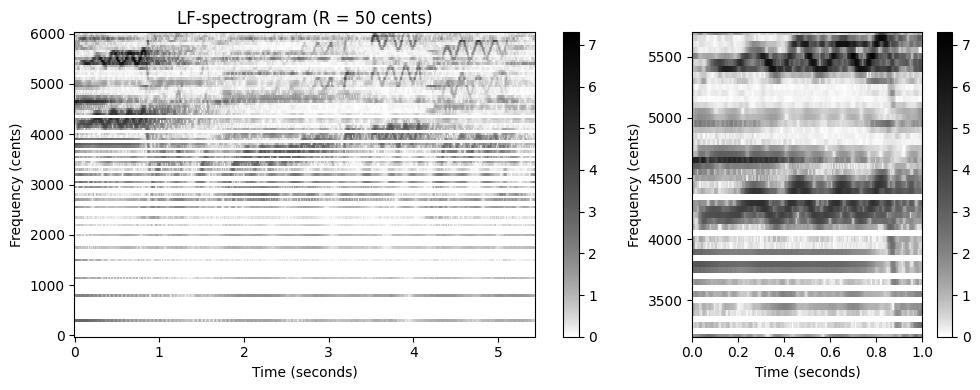

In [22]:
R = 50
F_min = 55.0
F_max = 1760.0

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)    

Y_LF_bin, F_coef_hertz, F_coef_cents = compute_y_lf_bin(Y, Fs, N, R, F_min=F_min, F_max=F_max)


plot_matrix(Y_LF_bin, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[0]], ylabel='Frequency (cents)',
                     title='LF-spectrogram (R = 50 cents)', colorbar=True, cmap=cmap);

plot_matrix(Y_LF_bin, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[1]], ylabel='Frequency (cents)',
                     title='', colorbar=True, cmap=cmap);

ylim_zoom_cents = [3200, 5700] 
xlim_zoom = [0,1]
ax[1].set_xlim(xlim_zoom)
ax[1].set_ylim(ylim_zoom_cents)
plt.tight_layout()

## Using Instantaneous Frequency

- 위에서 소개한 단순 비닝 접근 방식에서는 $\mathcal{Y}$의 선형 간격 주파수 정보가 비선형, 로그 방식으로 확장된다. 이것은 특히 $\mathcal{Y}_\mathrm{LF}$의 아래쪽 부분에서 볼 수 있는 주파수 방향의 아티팩트(예: 가로 흰색 줄무늬)를 초래한다. 이제 순간 주파수를 사용하여 이 문제를 완화할 수 있는 방법에 대해 논의해본다.

- 중심 주파수 $F_\mathrm{coef}(k)$를 사용하는 대신, 집합 $P^\mathrm{IF}(b,n) := \left\{k: \mathrm{Bin}\left(F_\mathrm{coef}^\mathrm{IF}(k, n)\right)=b\right\}$ ($b\in[1:B]$, $n\in\mathbb{Z}$)을 정의하는 정제된(refined) 주파수 추정치 $F_\mathrm{coef}^\mathrm{IF}(k,n)$를 사용한다.

- 이 새로운 빈 할당에서 다음을 설정하여 정제된 로그 주파수 스펙트로그램 $\mathcal{Y}_\mathrm{LF}^\mathrm{IF}$를 도출한다.
    - $ \mathcal{Y}_\mathrm{LF}^\mathrm{IF}(n,b) := \sum_{k \in P^\mathrm{IF}(b,n)}{\mathcal{Y} (n,k)} $
    - 각 프레임 인덱스 $n\in\mathbb{Z}$ 및 빈 인덱스 $b\in[1:B]$에 대해

- 이 수정의 효과는 다음 코드 셀에 설명되어 있다. 순간 주파수를 사용하면 STFT의 선형 주파수 그리드가 초래한 일부 문제가 완화된다. 특히 시간-주파수 패턴은 스펙트럼 계수가 단일 고조파 소스(source)에 명확하게 할당될 수 있을 때 더 선명해진다.

In [25]:
def p_bin_if(b, F_coef_IF, R=10.0, F_ref=55.0):
    """Computes binning mask for instantaneous frequency binning [FMP, Eq. (8.52)]

    Args:
        b (int): Bin index
        F_coef_IF (float): Instantaneous frequencies
        R (float): Frequency resolution in cents (Default value = 10.0)
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        mask (np.ndarray): Binning mask
    """
    mask = frequency_to_bin_index(F_coef_IF, R, F_ref) == b
    return mask


def compute_y_lf_if_bin(X, Fs, N, H, R=10, F_min=55.0, F_max=1760.0, gamma=0.0):
    """Binned Log-frequency Spectrogram with variable frequency resolution based on instantaneous frequency

    Args:
        X (np.ndarray): Complex spectrogram
        Fs (scalar): Sampling rate in Hz
        N (int): Window length in samples
        H (int): Hopsize in samples
        R (float): Frequency resolution in cents (Default value = 10)
        F_min (float): Lower frequency bound (reference frequency) (Default value = 55.0)
        F_max (float): Upper frequency bound (Default value = 1760.0)
        gamma (float): Logarithmic compression factor (Default value = 0.0)

    Returns:
        Y_LF_IF_bin (np.ndarray): Binned log-frequency spectrogram using instantaneous frequency
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        F_coef_cents (np.ndarray): Frequency axis in cents
    """
    # Compute instantaneous frequencies
    F_coef_IF = compute_if(X, Fs, N, H)
    freq_lim_mask = np.logical_and(F_coef_IF >= F_min, F_coef_IF < F_max)
    F_coef_IF = F_coef_IF * freq_lim_mask

    # Initialize ouput array and compute frequency axis
    B = frequency_to_bin_index(np.array([F_max]), R, F_min)[0] + 1
    F_coef_hertz = 2 ** (np.arange(0, B) * R / 1200) * F_min
    F_coef_cents = np.arange(0, B*R, R)
    Y_LF_IF_bin = np.zeros((B, X.shape[1]))

    # Magnitude binning
    if gamma == 0:
        Y = np.abs(X) ** 2
    else:
        Y = np.log(1 + np.float32(gamma)*np.abs(X))
    for b in range(B):
        coef_mask = p_bin_if(b, F_coef_IF, R, F_min)

        Y_LF_IF_bin[b, :] = (Y * coef_mask).sum(axis=0)
    return Y_LF_IF_bin, F_coef_hertz, F_coef_cents

C:\Users\JHCho\AppData\Local\Temp\ipykernel_2236\3605094473.py:23: RuntimeWarning: divide by zero encountered in log2
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)


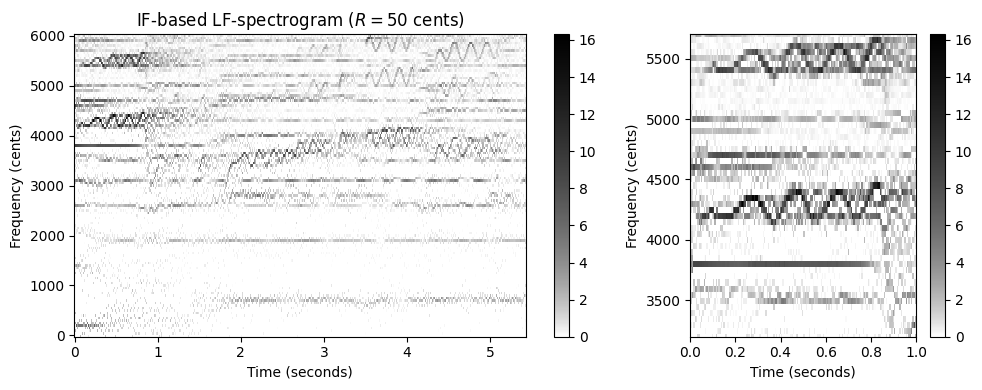

In [26]:
R = 50
F_min = 55.0
F_max = 1760.0
Y_LF_IF_bin, F_coef, F_coef_cents = compute_y_lf_if_bin(X, Fs, N, H, R=R, 
                                                        F_min=F_min, F_max=F_max, gamma=1)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)  
plot_matrix(Y_LF_IF_bin, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[0]], ylabel='Frequency (cents)',
                     title=r'IF-based LF-spectrogram ($R = %0.0f$ cents)'%R, colorbar=True, cmap=cmap);

plot_matrix(Y_LF_IF_bin, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[1]], ylabel='Frequency (cents)',
                     title='', colorbar=True, cmap=cmap);
ax[1].set_xlim(xlim_zoom)
ax[1].set_ylim(ylim_zoom_cents)
plt.tight_layout()

- 다음 그림에서는 $R=10$ 센트의 분해능을 사용하는 IF 기반 로그 주파수 스펙트로그램을 보여준다. 이 높은 주파수 분해능에서도 빈(empty) 주파수 빈으로 인한 아티팩트는 거의 보이지 않는다.

C:\Users\JHCho\AppData\Local\Temp\ipykernel_2236\3605094473.py:23: RuntimeWarning: divide by zero encountered in log2
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)


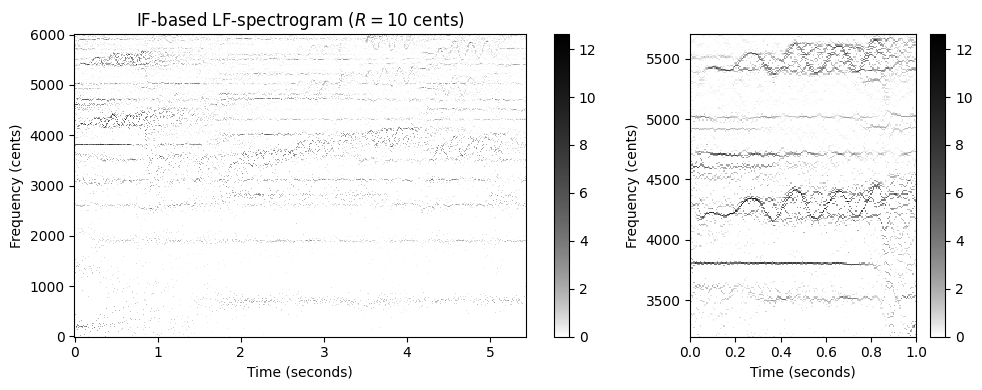

In [27]:
R = 10
Y_LF_IF_bin, F_coef, F_coef_cents = compute_y_lf_if_bin(X, Fs, N, H, R=R, 
                                                        F_min=F_min, F_max=F_max, gamma=1)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize) 
plot_matrix(Y_LF_IF_bin, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[0]], ylabel='Frequency (cents)', 
                     title='IF-based LF-spectrogram ($R = %0.0f$ cents)'%R, colorbar=True, cmap=cmap);

plot_matrix(Y_LF_IF_bin, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[1]], ylabel='Frequency (cents)', 
                     title='', colorbar=True, cmap=cmap);
ax[1].set_xlim(xlim_zoom)
ax[1].set_ylim(ylim_zoom_cents)
plt.tight_layout()

## 고조파 합산 (Harmonic Summation)

- 음악 톤과 같은 사운드 이벤트는 (대략) 기본 주파수의 정수배인 고조파와 함께 기본 주파수와 연관되어 있다. 따라서 녹음된 멜로디의 스펙트로그램 표현은 일반적으로 서로 위에 쌓인 주파수 궤적의 전체 계열을 나타낸다. 크로마 시간-주파수 패턴의 여러 모양을 활용하여 스펙트로그램 표현을 개선할 수 있다. 
- 방법은 **고조파 합산**(**harmonic summation**)이라고도 하는 기술로, 적절하게 가중된 합계를 형성하여 주파수와 해당 고조파를 공동으로 고려하는 것이다.
- $H\in\mathbb{N}$를 합계에서 고려할 고조파 수라고 하자. 그런 다음 스펙트로그램 표현 $\mathcal{Y}$가 주어지면 다음을 설정하여 고조파 합 스펙트로그램 $\tilde{\mathcal{Y}}$를 정의한다.
     - $ \tilde{\mathcal{Y}}(n,k) := \sum_{h=1}^{H} \alpha^{h-1} \cdot \mathcal{Y}(n,k\cdot h) $
     - for $n,k\in\mathbb{Z}$ ($\mathcal{Y}$가 주파수 방향에서 적절하게 제로-패딩 되어 있다고 가정).
- 합계에서 고조파는 가중 매개변수 $\alpha \in [0, 1]$를 사용하여 지수(exponentially)가중 될 수 있다.

In [30]:
def harmonic_summation(Y, num_harm=10, alpha=1.0):
    """Harmonic summation for spectrogram [FMP, Eq. (8.54)]

    Args:
        Y (np.ndarray): Magnitude spectrogram
        num_harm (int): Number of harmonics (Default value = 10)
        alpha (float): Weighting parameter (Default value = 1.0)

    Returns:
        Y_HS (np.ndarray): Spectrogram after harmonic summation
    """
    Y_HS = np.zeros(Y.shape)
    Y_zero_pad = np.vstack((Y, np.zeros((Y.shape[0]*num_harm, Y.shape[1]))))
    K = Y.shape[0]
    for k in range(K):
        harm_idx = np.arange(1, num_harm+1)*(k)
        weights = alpha ** (np.arange(1, num_harm+1) - 1).reshape(-1, 1)
        Y_HS[k, :] = (Y_zero_pad[harm_idx, :] * weights).sum(axis=0)
    return Y_HS

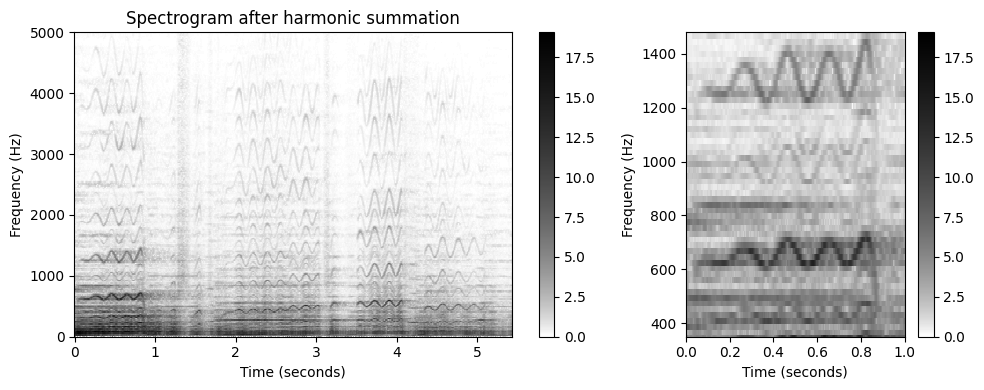

In [31]:
Y_HS = harmonic_summation(Y, num_harm=10)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)        

plot_matrix(Y_HS, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[0]], title='Spectrogram after harmonic summation', colorbar=True, cmap=cmap);
ax[0].set_ylim([0, 5000])
plot_matrix(Y_HS, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[1]], title='', colorbar=True, cmap=cmap);
ax[1].set_ylim(ylim_zoom)
ax[1].set_xlim(xlim_zoom)

plt.tight_layout()

## Salience Representation

- $\mathcal{Y}_\mathrm{LF}$ 또는 $\mathcal{Y}_\mathrm{LF}^\mathrm{IF}$와 같은 로그 주파수 스펙트로그램 표현에 유사한 구조를 적용할 수 있다.
- 단, 이 경우 고조파 합산의 수정이 필요하다. 특히, 로그 주파수 영역에서 작업할 때 주파수와 그것의 고조파 간의 관계는 곱셈이 아니라 덧셈이다. 예를 들어, 로그 주파수 스펙트로그램 $\mathcal{Y}_\mathrm{LF}^\mathrm{IF}$의 경우 고조파 합계 버전 $\mathcal{Z}:=\tilde{ \mathcal{Y}}_\mathrm{LF}^\mathrm{IF}$를 다음과 같이 설정하여 얻는다.
     - $\mathcal{Z}(n,b) := \sum_{h=1}^{H} \alpha^{h-1} \cdot \mathcal{Y}_\mathrm{LF}^\mathrm{ IF}\left(n,b+ \left\lfloor \frac{1200}{R}\log_2(h)\right\rfloor\right) $
    
- 톤 주파수 성분의 돌출성(salience)을 강조하여 $\mathcal{Z}$는 **돌출(salience) 표현**이라고도 한다.
- 다음 코드 셀은 로그 주파수 표현을 위한 고조파 합계를 구현한다.

In [36]:
def harmonic_summation_lf(Y_LF_bin, R, num_harm=10, alpha=1.0):
    """Harmonic summation for log-frequency spectrogram [FMP, Eq. (8.55)]

    Args:
        Y_LF_bin (np.ndarray): Log-frequency spectrogram
        R (float): Frequency resolution in cents
        num_harm (int): Number of harmonics (Default value = 10)
        alpha (float): Weighting parameter (Default value = 1.0)

    Returns:
        Y_LF_bin_HS (np.ndarray): Log-frequency spectrogram after harmonic summation
    """
    Y_LF_bin_HS = np.zeros(Y_LF_bin.shape)
    pad_len = int(np.floor(np.log2(num_harm) * 1200 / R))
    Y_LF_bin_zero_pad = np.vstack((Y_LF_bin, np.zeros((pad_len, Y_LF_bin.shape[1]))))
    B = Y_LF_bin.shape[0]
    for b in range(B):
        harmonics = np.arange(1, num_harm+1)
        harm_idx = b + np.floor(np.log2(harmonics) * 1200 / R).astype(np.int64)
        weights = alpha ** (np.arange(1, num_harm+1) - 1).reshape(-1, 1)
        Y_LF_bin_HS[b, :] = (Y_LF_bin_zero_pad[harm_idx, :] * weights).sum(axis=0)
    return Y_LF_bin_HS

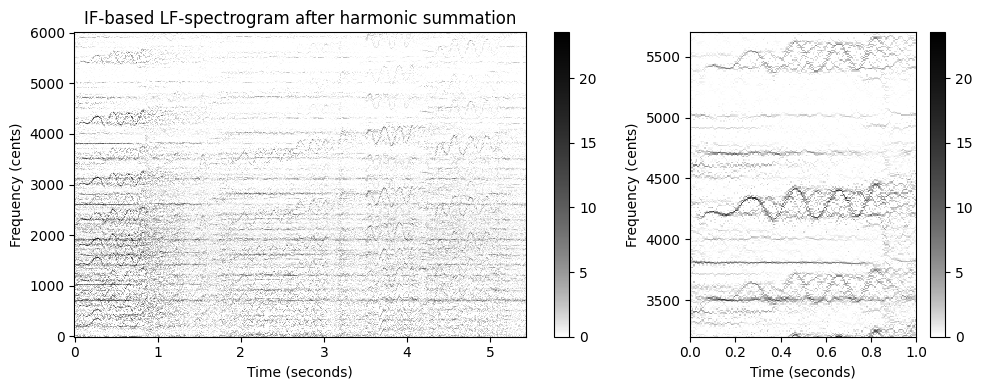

In [37]:
Y_LF_IF_bin_HS = harmonic_summation_lf(Y_LF_IF_bin, num_harm=10, R=R)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)   

plot_matrix(Y_LF_IF_bin_HS, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[0]], ylabel='Frequency (cents)', 
                     title='IF-based LF-spectrogram after harmonic summation', colorbar=True, cmap=cmap);

plot_matrix(Y_LF_IF_bin_HS, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[1]], ylabel='Frequency (cents)', 
                     title='', colorbar=True, cmap=cmap);
ax[1].set_xlim(xlim_zoom)
ax[1].set_ylim(ylim_zoom_cents)
plt.tight_layout()

- 시각화를 보면 고조파 합산의 효과가 크지 않은 것 처럼 보인다. 최종 결과에 상당한 영향을 미칠 수 있는 많은 매개 변수가 있다. 특히, IF 기반 선명화(sharpening)와 결합된 높은 주파수 분해능은 **고조파 관련 빈에서 작은 편차**로 인해 고조파 합산에 문제를 일으킬 수 있다. 

- 고조파 합산의 견고성을 높이는 간단한 방법은 **주파수 축을 따라 스무딩(smoothing) 단계**를 도입하는 것이다. 다음 그림에 표시된 대로 이 단계는 결과 돌출 표현에 상당한 영향을 미칠 수 있다.

- 다음 코드 셀은 최종 돌출 표현을 계산하기 위한 구현을 제공하여 전체 절차를 요약한다.

In [38]:
def compute_salience_rep(x, Fs, N, H, R, F_min=55.0, F_max=1760.0, num_harm=10, freq_smooth_len=11, alpha=1.0,
                         gamma=0.0):
    """Salience representation [FMP, Eq. (8.56)]

    Args:
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling frequency
        N (int): Window length in samples
        H (int): Hopsize in samples
        R (float): Frequency resolution in cents
        F_min (float): Lower frequency bound (reference frequency) (Default value = 55.0)
        F_max (float): Upper frequency bound (Default value = 1760.0)
        num_harm (int): Number of harmonics (Default value = 10)
        freq_smooth_len (int): Filter length for vertical smoothing (Default value = 11)
        alpha (float): Weighting parameter (Default value = 1.0)
        gamma (float): Logarithmic compression factor (Default value = 0.0)

    Returns:
        Z (np.ndarray): Salience representation
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        F_coef_cents (np.ndarray): Frequency axis in cents
    """
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, pad_mode='constant')
    Y_LF_IF_bin, F_coef_hertz, F_coef_cents = compute_y_lf_if_bin(X, Fs, N, H, R, F_min, F_max, gamma=gamma)
    # smoothing
    Y_LF_IF_bin = ndimage.filters.convolve1d(Y_LF_IF_bin, np.hanning(freq_smooth_len), axis=0, mode='constant')
    Z = harmonic_summation_lf(Y_LF_IF_bin, R=R, num_harm=num_harm, alpha=alpha)
    return Z, F_coef_hertz, F_coef_cents

C:\Users\JHCho\AppData\Local\Temp\ipykernel_2236\3605094473.py:23: RuntimeWarning: divide by zero encountered in log2
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\JHCho\AppData\Local\Temp\ipykernel_2236\1281760022.py:26: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Y_LF_IF_bin = ndimage.filters.convolve1d(Y_LF_IF_bin, np.hanning(freq_smooth_len), axis=0, mode='constant')


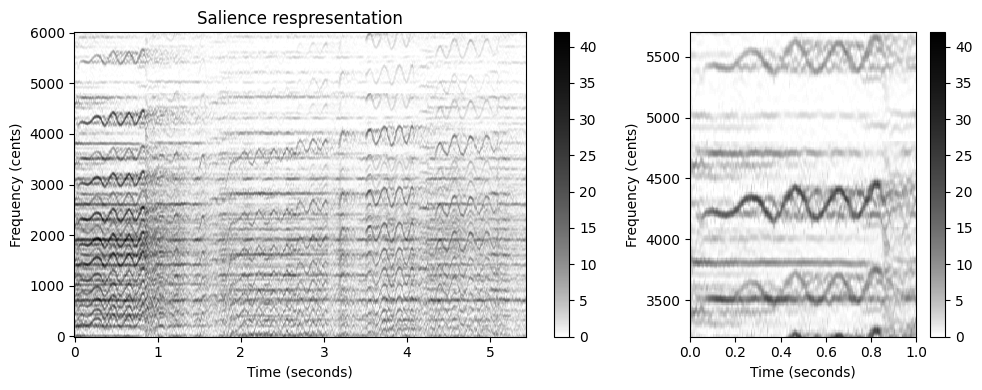

In [35]:
Z, F_coef_hertz, F_coef_cents = compute_salience_rep(x, Fs, N=1024, H=128, R=10, 
                                                     num_harm=10, freq_smooth_len=11, alpha=1, gamma=1)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)   

plot_matrix(Z, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[0]], ylabel='Frequency (cents)',
                     title='Salience respresentation', colorbar=True, cmap=cmap);

plot_matrix(Z, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[1]], ylabel='Frequency (cents)', 
                     title='', colorbar=True, cmap=cmap);
ax[1].set_xlim(xlim_zoom)
ax[1].set_ylim(ylim_zoom_cents)
plt.tight_layout()

- 이 그림에서 볼 수 있듯이 합산 프로세스는 지배적인 톤 구성 요소를 증폭하는 반면 순간 주파수 추정에 의해 도입된 노이즈와 같은 아티팩트가 감쇠된다. 
- 단, 단점은 프로세스가 특히 스펙트로그램의 낮은 주파수 범위에 나타나는 **고스트(ghost) 요소**를 생성한다는 것이다(예: 오른쪽 플롯에서 주파수 $3500$ 센트 주변의 비브라토 참조). 그러나 이것은 지배 주파수 궤적(predominant frequency trajectories)만을 찾는 경우에는 큰 문제가 되지 않는다.

- 요약하면, salience 표현 $\mathcal{Z}$의 구성은 몇 가지 가정과 관찰에 의해 동기가 부여된다.
     * 첫째, 로그 주파수 비닝은 주파수의 로그 인식과 음 피치의 음악적 개념을 설명한다.
     * 둘째, 순간 주파수를 사용하면 주파수 추정의 정확도가 향상된다.
     * 셋째, 고조파 합산은 규칙적인 간격의 주파수 성분을 증폭시킨다. 이것은 톤의 에너지가 기본 주파수에 포함되어 있을 뿐만 아니라 전체 고조파 스펙트럼에 퍼져 있다는 사실을 설명한다.

- 게다가, 우리는 고조파 합산 이전의 추가 스무딩 단계가 최종 돌출 표현에서 상당한 개선을 가져올 수 있음을 확인했다.
- 일반적으로 고해상도로 샘플링된 데이터에 **로컬** 연산을 적용할 때 데이터의 작은 편차나 이상값은 상당한 성능 저하로 이어질 수 있다. 이러한 상황에서 추가 필터링 단계(예: 가우스 커널 또는 중앙값 필터링을 사용한 컨볼루션)는 일부 문제를 완화하는 데 도움이 될 수 있다.
- 위에서 본 경우 스무딩은 고조파 합산을 적용하기 전에 주파수 빈의 작은 편차의 균형을 맞추는 데 도움이 되었다. 노벨티 기반 경계 감지와 관련하여 유사한 전략을 적용했다. 여기서 노벨티함수 $\Delta_\mathrm{Structure}$를 계산하기 위해서는 연속되는 특징들 간의 지역적 차이를 계산하기 전에 추가적인 필터링이 유리했다.

# Fundamental Frequency Tracking

## Frequency Trajectory

- 일반적으로 **멜로디**(melody)는 일관된 개체를 형성하고 특정 음악적 아이디어를 표현하는 음악 톤의 선형적 연속(succession)으로 정의될 수 있다. 음악 처리의 다른 많은 개념과 마찬가지로 멜로디의 개념은 다소 모호하다. 이 노트북에서는 음악이 오디오 녹음의 형태로 제공되는 시나리오(심볼릭 음악 표현이 아님)를 고려한다.
- 또한 음의 순서를 추정하는 것이 아니라 음의 피치에 해당하는 주파수 값의 순서를 결정하는 것이 목표이다. 연속적인 주파수 글라이드(glides) 및 변조(modulation)를 캡처할 수 있는 시간 경과에 따른 이러한 주파수 경로를 **주파수 궤적(trajectory)** 이라고 한다.
- 특히 멜로디 음표의 **기본 주파수 값**(**F0 값**이라고도 함)에 관심이 있다. 그 결과의 궤적은 **F0-궤적**이라고도 한다.


- 수학적으로 F0-궤적을 다음의 함수로 모델링한다.
    - $ \eta:\mathbb{R}\to\mathbb{R}\cup\{\ast\},$
    - 이는 각 시점 $t\in\mathbb{R}$(초 단위)에 주파수 값 $\eta(t)\in\mathbb{R}$(Hertz 단위) 또는 기호 $\eta(n)=\ast$를 할당한다. .
- $\eta(t)=\ast$은 이 시점에서 멜로디 성분에 해당하는 F0 값이 없다는 뜻이다.


- 예시로 위에서 봤던 "Der Freischütz" - Carl Maria von Weber를 보자. 악보 표현에서 주요 멜로디는 가사와 함께 표시되어 있다. 소프라노 가수의 퍼포먼스에서 멜로디는 F0-값의 궤적에 해당한다. 표시된 심볼릭 표현과 반대로, 몇몇 음은 부드럽게 연결되어 있다. 더욱이 비브라토에 따른 뚜렷한 주파수 변조를 되려 관찰 할 수 있다.

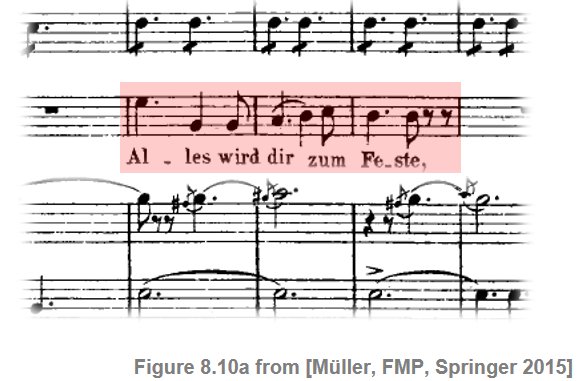

In [40]:
ipd.display(Image(path_img+"FMP_C8_F10a.png", width="300px"))
ipd.display(Audio(path_data+"FMP_C8_F10_Weber_Freischuetz-06_FreiDi-35-40.wav"))

- 다음 그림에서는 가수의 F0-궤적(주석 파일에서 읽음)을 시각화한다. 하나는 선형 주파수 축(Hertz로 주어짐)과 로그 주파수 축(참고 주파수$\omega_\mathrm{ref}=55~\mathrm{Hz}$ 에 상대적인 센트로 주어짐)으로 한 번 표시된다.

In [41]:
def hz_to_cents(F, F_ref=55.0):
    """Converts frequency in Hz to cents

    Args:
        F (float or np.ndarray): Frequency value in Hz
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        F_cent (float or np.ndarray): Frequency in cents
    """
    F_cent = 1200 * np.log2(F / F_ref)
    return F_cent


def cents_to_hz(F_cent, F_ref=55.0):
    """Converts frequency in cents to Hz

    Args:
        F_cent (float or np.ndarray): Frequency in cents
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        F (float or np.ndarray): Frequency in Hz
    """
    F = F_ref * 2 ** (F_cent / 1200)
    return F

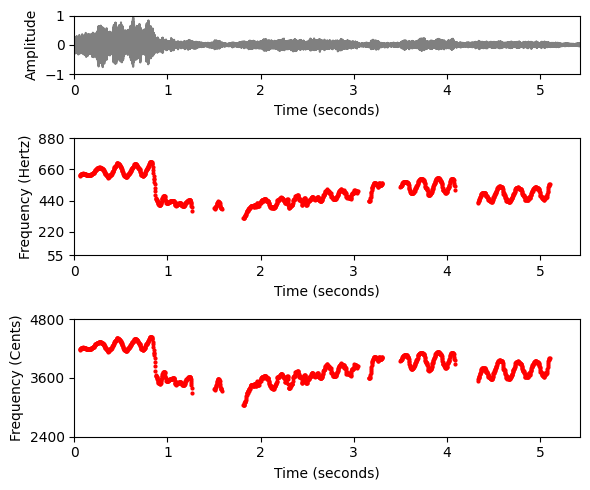

In [44]:
# Load audio
fn_wav = 'FMP_C8_F10_Weber_Freischuetz-06_FreiDi-35-40.wav'

x, Fs = librosa.load(path_data+fn_wav)
x_duration = len(x)/Fs
ipd.Audio(x, rate=Fs)

# Read in the F0 trajectory
fn_traj = 'FMP_C8_F10_Weber_Freischuetz-06_FreiDi-35-40_F0-user-Book.csv'
traj_df = pd.read_csv(path_data+fn_traj,sep=';', keep_default_na=False, header=0)
traj = traj_df.values

fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 2, 2]}, figsize=(6,5))
plot_signal(x, Fs, ax=ax[0], xlabel='');
ax[0].set_ylim((-1,1));
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('Time (seconds)')

traj_plot = traj[traj[:, 1]>0]
ax[1].plot(traj_plot[:, 0], traj_plot[:, 1], color='r', markersize=4, marker='.', linestyle='');
ax[1].set_ylim((55,880));
ax[1].set_yticks([55, 220, 440, 660, 880])
ax[1].set_xlim((0, x_duration));
ax[1].set_ylabel('Frequency (Hertz)')
ax[1].set_xlabel('Time (seconds)')
plt.tight_layout()

ax[2].plot(traj_plot[:, 0], hz_to_cents(traj_plot[:, 1]), color='r', markersize=4, marker='.', linestyle='');
ax[2].set_ylim((2400, 4800));
ax[2].set_yticks([2400, 3600, 4800])
ax[2].set_xlim((0, x_duration));
plt.xlabel('Time (seconds)')
ax[2].set_ylabel('Frequency (Cents)')
plt.tight_layout()